<a href="https://colab.research.google.com/github/pavelpryadokhin/Telegram-BOT-ChatGPT/blob/main/Telegram_%D0%B1%D0%BE%D1%82_c_ChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install aiogram
!pip install nest_asyncio
!pip install aiosqlite
import nest_asyncio
nest_asyncio.apply()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.7/575.7 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install openai mwclient mwparserfromhell tiktoken


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import ast

embeddings_path = "/content/Saint Petersburg.csv"
df = pd.read_csv(embeddings_path)

# Конвертируем эмбеддинги из строк в списки
df['embedding'] = df['embedding'].apply(ast.literal_eval)
df.head()


,text,embedding
0,Template:SaintPetersburg-stub\n\n{{asbox\n| im...,"[-0.019218014553189278, 0.0011772229336202145,..."
1,Naval Cadet Corps (Russia)\n\n[[image:Naval In...,"[-0.017364492639899254, 0.002858232008293271, ..."
2,Naval Cadet Corps (Russia)\n\n==History==\n\n[...,"[-0.0005884834681637585, 0.005313960835337639,..."
3,Naval Cadet Corps (Russia)\n\n==Post Revolutio...,"[0.004730003885924816, -0.012998382560908794, ..."
4,Demographics of Saint Petersburg\n\n{{Infobox ...,"[0.02548605389893055, -0.0038593898061662912, ..."


In [ ]:
import os
import asyncio
from openai import AsyncOpenAI
from scipy import spatial  # вычисляет сходство векторов
import tiktoken
import getpass

GPT_MODEL = "gpt-3.5-turbo"

os.environ["OPENAI_API_KEY"] = getpass.getpass("Введите OpenAI API Key:")
client = AsyncOpenAI(
 # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

EMBEDDING_MODEL = "text-embedding-ada-002"

async def strings_ranked_by_relatedness(
    query: str,
    df: pd.DataFrame,
    relatedness_fn=lambda x, y: 1 - spatial.distance.cosine(x, y),
    top_n: int = 100
) -> tuple[list[str], list[float]]:
    """Возвращает строки и схожести, отсортированные от большего к меньшему"""

    client = AsyncOpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    # Получение эмбеддинга запроса
    query_embedding_response = await client.embeddings.create(
        model=EMBEDDING_MODEL,
        input=query,
    )

    query_embedding = query_embedding_response.data[0].embedding

    # Сравниваем пользовательский запрос с каждой строкой DataFrame
    strings_and_relatednesses = [
        (row["text"], relatedness_fn(query_embedding, row["embedding"]))
        for i, row in df.iterrows()
    ]

    # Сортируем по убыванию схожести
    strings_and_relatednesses.sort(key=lambda x: x[1], reverse=True)

    # Преобразуем в кортеж из списков
    strings, relatednesses = zip(*strings_and_relatednesses)

    # Возвращаем n лучших результатов
    return strings[:top_n], relatednesses[:top_n]


Введите OpenAI API Key:··········


In [ ]:
async def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Возвращает число токенов в строке для заданной модели"""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

async def query_message(
    query: str,
    df: pd.DataFrame,
    model: str,
    token_budget: int
) -> str:
    """Возвращает сообщение для GPT с соответствующими исходными текстами"""

    strings, relatednesses = await strings_ranked_by_relatedness(query, df)

    message = 'Use the below articles on the Saint Petersburg to answer the subsequent question. If the answer cannot be found in the articles, write "I could not find an answer."'
    question = f"\n\nQuestion: {query}"

    for string in strings:
        next_article = f'\n\nWikipedia article section:\n"""\n{string}\n"""'
        if await num_tokens(message + next_article + question, model=model) > token_budget:
            break
        else:
            message += next_article

    return message + question

async def ask(
    query: str,
    df: pd.DataFrame = df,
    model: str = GPT_MODEL,
    token_budget: int = 4096 - 500,
    print_message: bool = False
) -> str:
    """Отвечает на вопрос, используя GPT и базу знаний."""

    message = await query_message(query, df, model=model, token_budget=token_budget)

    if print_message:
        print(message)

    messages = [
        {"role": "system", "content": "You answer questions about the Saint Petersburg."},
        {"role": "user", "content": message},
    ]

    response = await client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0
    )

    response_message = response.choices[0].message.content
    return response_message

In [ ]:
import asyncio
import logging
from aiogram import Bot, Dispatcher, types
from aiogram.filters.command import Command
from aiogram.utils.keyboard import ReplyKeyboardBuilder
from aiogram import F

# Включаем логирование, чтобы не пропустить важные сообщения
logging.basicConfig(level=logging.INFO)

# Замените "YOUR_BOT_TOKEN" на токен, который вы получили от BotFather
API_TOKEN = 'YOUR_BOT_TOKEN'


# Объект бота
bot = Bot(token=API_TOKEN)
# Диспетчер
dp = Dispatcher()

# Хэндлер на команду /start
@dp.message(Command("start"))
async def cmd_start(message: types.Message):
    # Создаем сборщика клавиатур типа Reply
    builder = ReplyKeyboardBuilder()
    # Добавляем в сборщик одну кнопку
    builder.add(types.KeyboardButton(text="Помощь"))

    # Прикрепляем кнопки к сообщению
    await message.answer("Добро пожаловать! Спросите любую информацию о Санкт-Петербурге!", reply_markup=builder.as_markup(resize_keyboard=True))

# Хэндлер на команды /help
@dp.message(F.text=="Помощь")
@dp.message(Command("help"))
async def cmd_quiz(message: types.Message):
    # Отправляем новое сообщение без кнопок
    await message.answer(f"Тематика: Санкт-Петербург")
    await message.answer(f"Число записей в базе данных {len(df)}")
    await message.answer(f"Спрашивайте любую информацию о Санкт-Петербурге на английском языке, если информация не будет найдена то выведет результат 'I could not find an answer'")


# Хэндлер на запросы
@dp.message(F.text)
async def cmd_ask(message: types.Message):
    # Отправляем новое сообщение без кнопок
    query = message.text
    response = await ask(query)
    await message.answer(response)



# Запуск процесса поллинга новых апдейтов
async def main():

    await dp.start_polling(bot)
if __name__ == "__main__":
    asyncio.run(main())

адрес бота https://t.me/SPBinf_bot

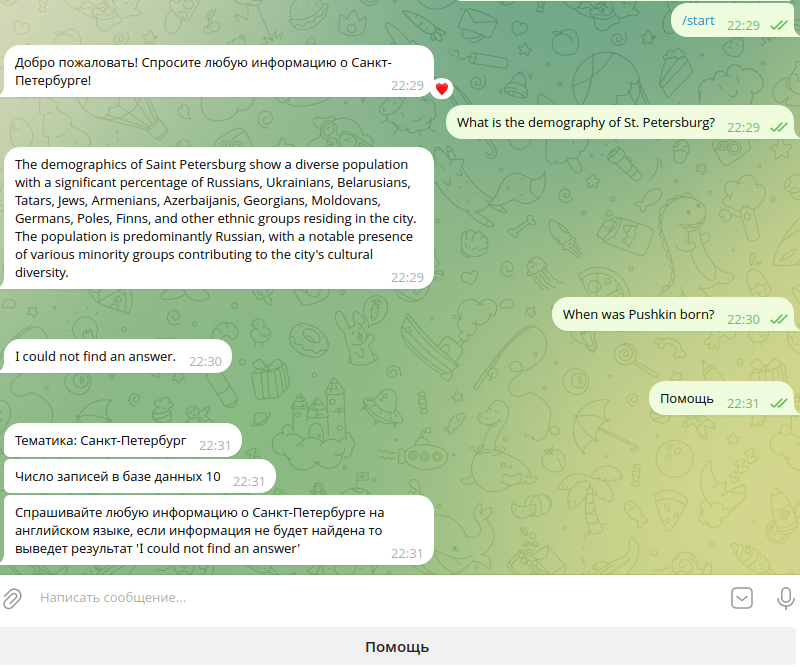